#XRAY PNEUMONIA DETECTION WITH CONVOLUTIONAL NEURAL NETWORKS, USING THE RESNET18 ARCHITECTURE

Using data from https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

#INTRODUCTION
Pneumonia, simply put, is a killer, accounting for over 15% of under-five deaths. It can't be caused by bacteria, viruses or even fungi. On some occassions, the nature of chest X-ray might help deduce the causative agent of pneumonia in patients. 

In the lectures, wardrounds, clinics etc, we're being trained to interpret xrays. But let's face it; learning to interpret xrays perfectly, takes years of real-world practice. Training a machine learning model that can accurately interprete xray images, would really help save time for radiologists and allow them to concentrate on more specialized tasks, while helping other health personel make better interpretations (especially in areas with low workforce of medics).

In this project, i'll be training a model which aims to interprete Xray images and classify them as either normal, or has features of pneumonia.

To do this, I'll be using a chest xray dataset from kaggle (you can access the datasets here: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)

This dataset contains almost 6000 images of both normal and abnormal chest xrays. However, the only abnormality captured in this dataset is pneumonia. In the near future, i'll be training a model with a dataset that captures a wide array of chest abnormalities

In order to train this model, I'll be using convolutional neural networks, with the resnet18 architecture, using pytorch and the fastai library.



In [1]:
!pip install -Uqq fastbook
!pip install opendatasets as od

     |████████████████████████████████| 727kB 24.4MB/s 
     |████████████████████████████████| 194kB 56.7MB/s 
     |████████████████████████████████| 1.1MB 52.0MB/s 
     |████████████████████████████████| 51kB 9.7MB/s 
     |████████████████████████████████| 61kB 10.3MB/s 


In [2]:
import fastbook
fastbook.setup_book()

Mounted at /content/gdrive


In [3]:
import opendatasets as od

In [4]:
from fastbook import *
from fastai.vision.widgets import *


##Getting Our Datasets

We'll be using the opendatasets library to download our data from Kaggle

Note that to download dataset from kaggle, you'll need to authenticate your account with your user name and kaggle key. both a located in a json file which can be generated from your kaggle account

In [5]:
od.download('https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sadiqbasit
Your Kaggle Key: ··········


  0%|          | 7.00M/2.29G [00:00<00:35, 70.1MB/s]

100%|██████████| 2.29G/2.29G [00:29<00:00, 82.2MB/s]


The dataset has 3 main folders for the training set, validation set and test set. however, I'll be using the training set for both training and validation. that way, we have two different sets of test datasets for testing out our model.

In [6]:
path = '/content/chest-xray-pneumonia/chest_xray/train'

In [ ]:
#let's verify that all the contents of our datasets folder, are images
fns = get_image_files('/content/chest-xray-pneumonia/chest_xray/train')
failed = verify_images(fns)
failed

(#0) []

The result above shows that all the contents of our datasets are images


#Now lets create a Dataloader for our datasets

In [7]:
xray = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [8]:
# create dataloader object
dls = xray.dataloaders(path)

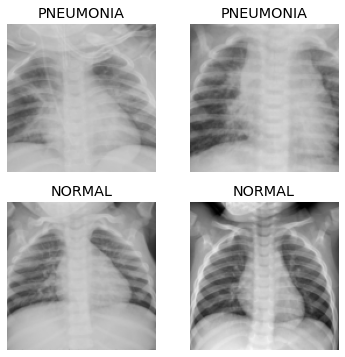

In [9]:
# let's view a sample of our data

dls.valid.show_batch(max_n=4, nrows=2)

#Data Augmentation

Because of the nature of chest pneumonia, lesions could be unilobar or multilobar. In other word, the lesions our model is supposed to look for, could be located in just one location, which could be cropped out if care is not taken.

For this reason, simply resizing our images is not enough. Hence we'll be feeding multiple chunks of individual images to our model for training.

That way our model can have a closer examination of lesions in various locations of our xray images.

Data augmentation could actually result in lesser accuracy, but the accuracy will be more realistic, and more applicable to real-world scenarios, since the entire components of individual images are been examined

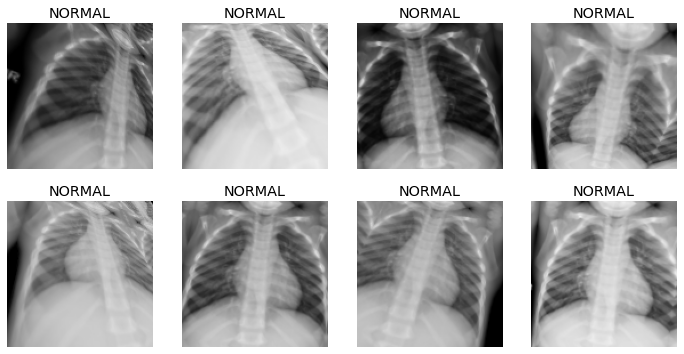

In [11]:
# or perform data augmentation
xray = xray.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = xray.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

# Training the model

It's now time for us to train our model.

As stated before, we'll be using Convolutional Neural Networs with the resnet18 architecture


In [12]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.699568,0.881879,0.166826,01:03


epoch,train_loss,valid_loss,error_rate,time
0,0.326654,0.477934,0.095877,01:06
1,0.246340,0.179308,0.051774,01:04
2,0.168205,0.113732,0.044104,01:05
3,0.138575,0.131769,0.045062,01:05


# Result:

As seen above, after training our model for a couple of epochs, we were able to yiels a validation loss of 0.132 and an erro_rate of 0.045.

Which means, our accuracy was was over 95% after 5 minutes of training! State of the arts, right!

Let's now use a confusion matrix to get a visual display of how well our model did

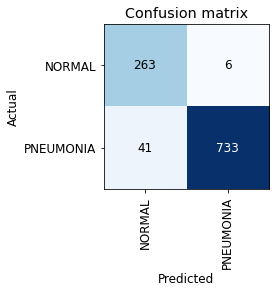

In [13]:
#see mistake model made with a confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

From the confusion matrix above our model made 996 right predictions and 47 wrong predictions.

Our model predicted 6 normal xrays as haveing features of pneumonia, and 41 abnormal xrays as being normal

Let's have a look at a couple of images from our dataset that had a higher loss. This is useful because radiologists can manually look at these images try to determine why some images where predicted wrongly

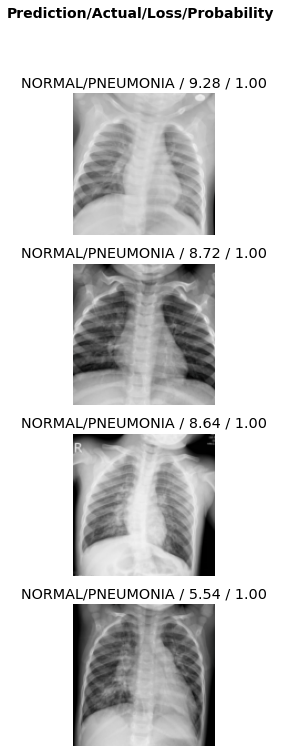

In [14]:
# visualize sample outputs with higher loss
interp.plot_top_losses(4, nrows=4)

The images above show the prediction vs actual for images with high loss.

Radiologists than then manually interprete these images and try to determine why a wrong prediction was made on them.

Fastai created a nice gui which allows us to manually look images with top losses, and either remove images which are improper for our datasets, or change their class. 

This can be done with the code below


In [15]:
cleaner = ImageClassifierCleaner(learn)
cleaner

First, you'll select the images you want to delete or whose class you want to change, and then apply an action from the dropdown, using the interactive gui above. then you can run the code below to to perform chosen action

In [ ]:
#uncomment
#for idx in cleaner.delete(): cleaner.fns[idx].unlink()

However, this manual cleaning should only be done by those who actually know what kind of outputs to expect. In this case, it wouldn't really be a good idea to delete these images, unless you can manually interprete them.

I can manually interprete chest xrays, but I'm not exceptional. for the sake of transparency, we'll live these data as they are, without deleting any of the images

#Testing our model on exterenal xrays

I'm goin to save my model and share it with my readers.

You should try using this model to test its accuracy on the test dataset

To test this model on individual images, We'll be creating an inference learner from our model, which takes the path to any image and returns its prediction confidence level.

In [16]:
#export file as .pkl
learn.export()

#check that file exists
path = Path()
path.ls(file_exts='.pkl')


(#1) [Path('export.pkl')]

In [17]:
#generate inference learner
learn_inf = load_learner(path/'export.pkl')

In [21]:
#get individual predictions
learn_inf.predict('/content/chest-xray-pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg') #replace path with your own image path


('NORMAL', tensor(0), tensor([0.7722, 0.2278]))

In [22]:
#to access classes in inference
learn_inf.dls.vocab


['NORMAL', 'PNEUMONIA']

# Conclusion

Our model was able to hit a pretty good accuracy within a short training period, but there's still a lot of work to be done.

For example, this dataset only differentiates between normal xrays and xrays with features of pneumonia. if you feed in an xray with a different abnormality (atelactasis for example), the model has no way of predicting this kind of abnormality, since it wasn't trained to do so.

A more clincically practical xray dataset for dection of abnormalities, is one which contains not only normal chest xrays and those with features of pneumonia, but also xrays with other abnormalities, like pleural effusion, cardiomegally, lung collapse, lung cancer, tuberculosis, etc. The dataset would prove even more useful, if specific areas where the abnormal findings are found on the xray

# Improving this further

You can (and should) try changing the training archtecture or transformations. you could also try increasing the size of the images.

Or better still, you could train this model with a different xray datasets and compare with this result.

Thanks.